In [11]:
import os
import pydicom
import numpy as np
import pywt
import matplotlib.pyplot as plt

def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".dcm"):
            filepath = os.path.join(directory, filename)
            dicom_files.append(pydicom.dcmread(filepath).pixel_array)
    return np.array(dicom_files)

def perform_2d_wavelet_transform(data):
    coeffs = pywt.dwt2(data, wavelet='haar', mode='periodization')
    coeffs_dict = {'aa': coeffs[0], 'ad': coeffs[1][0], 'da': coeffs[1][1], 'dd': coeffs[1][2]}
    return coeffs_dict

def perform_3d_wavelet_transform(data):
    coeffs = pywt.dwtn(data, wavelet='haar', mode='periodization')
    return coeffs

def normalize(data):
    data = np.abs(data)
    data = data / np.max(data)
    return data

def display_images(data, title, transform_type):
    if transform_type == '3D':
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2x4 grid
        keys = ['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']  
        labels = {'aaa': 'LLL', 'aad': 'LLH', 'ada': 'LHL', 'add': 'LHH', 
                  'daa': 'HLL', 'dad': 'HLH', 'dda': 'HHL', 'ddd': 'HHH'}
        for i, key in enumerate(keys):
            row, col = divmod(i, 4)
            value = data[key]
            if value.ndim == 3:
                value = value[0]  # Select the first slice if 3D
            value = normalize(value)  # Normalize the data
            axes[row, col].imshow(value, cmap='gray')
            axes[row, col].set_title(f'{title} - {labels[key]}')
            axes[row, col].axis('off')
    elif transform_type == '2D':
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1x4 grid
        keys = ['aa', 'ad', 'da', 'dd']  # Explicit order
        labels = {'aa': 'LL', 'ad': 'LH', 'da': 'HL', 'dd': 'HH'}
        for i, key in enumerate(keys):
            value = data[key]
            value = normalize(value)  # Normalize the data
            axes[i].imshow(value, cmap='gray')
            axes[i].set_title(f'{title} - {labels[key]}')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Directory containing the DICOM files
dicom_directory = 'Test_Sets/CT/3/DICOM_anon/'

# Read DICOM files
dicom_data = read_dicom_files(dicom_directory)



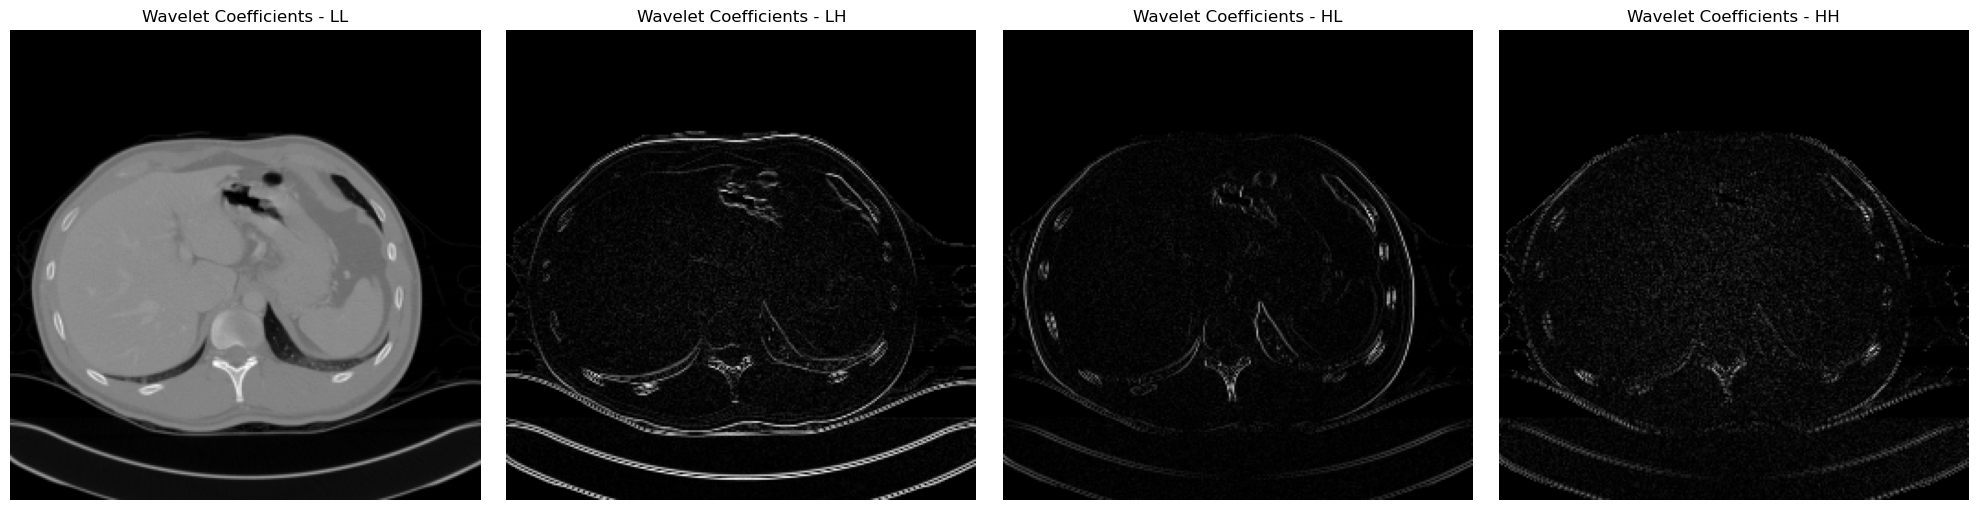

In [12]:
# Perform 2D wavelet transform
wavelet_coeffs_2d = perform_2d_wavelet_transform(dicom_data[0])  # Use the first slice for 2D transform
display_images(wavelet_coeffs_2d, 'Wavelet Coefficients', '2D')

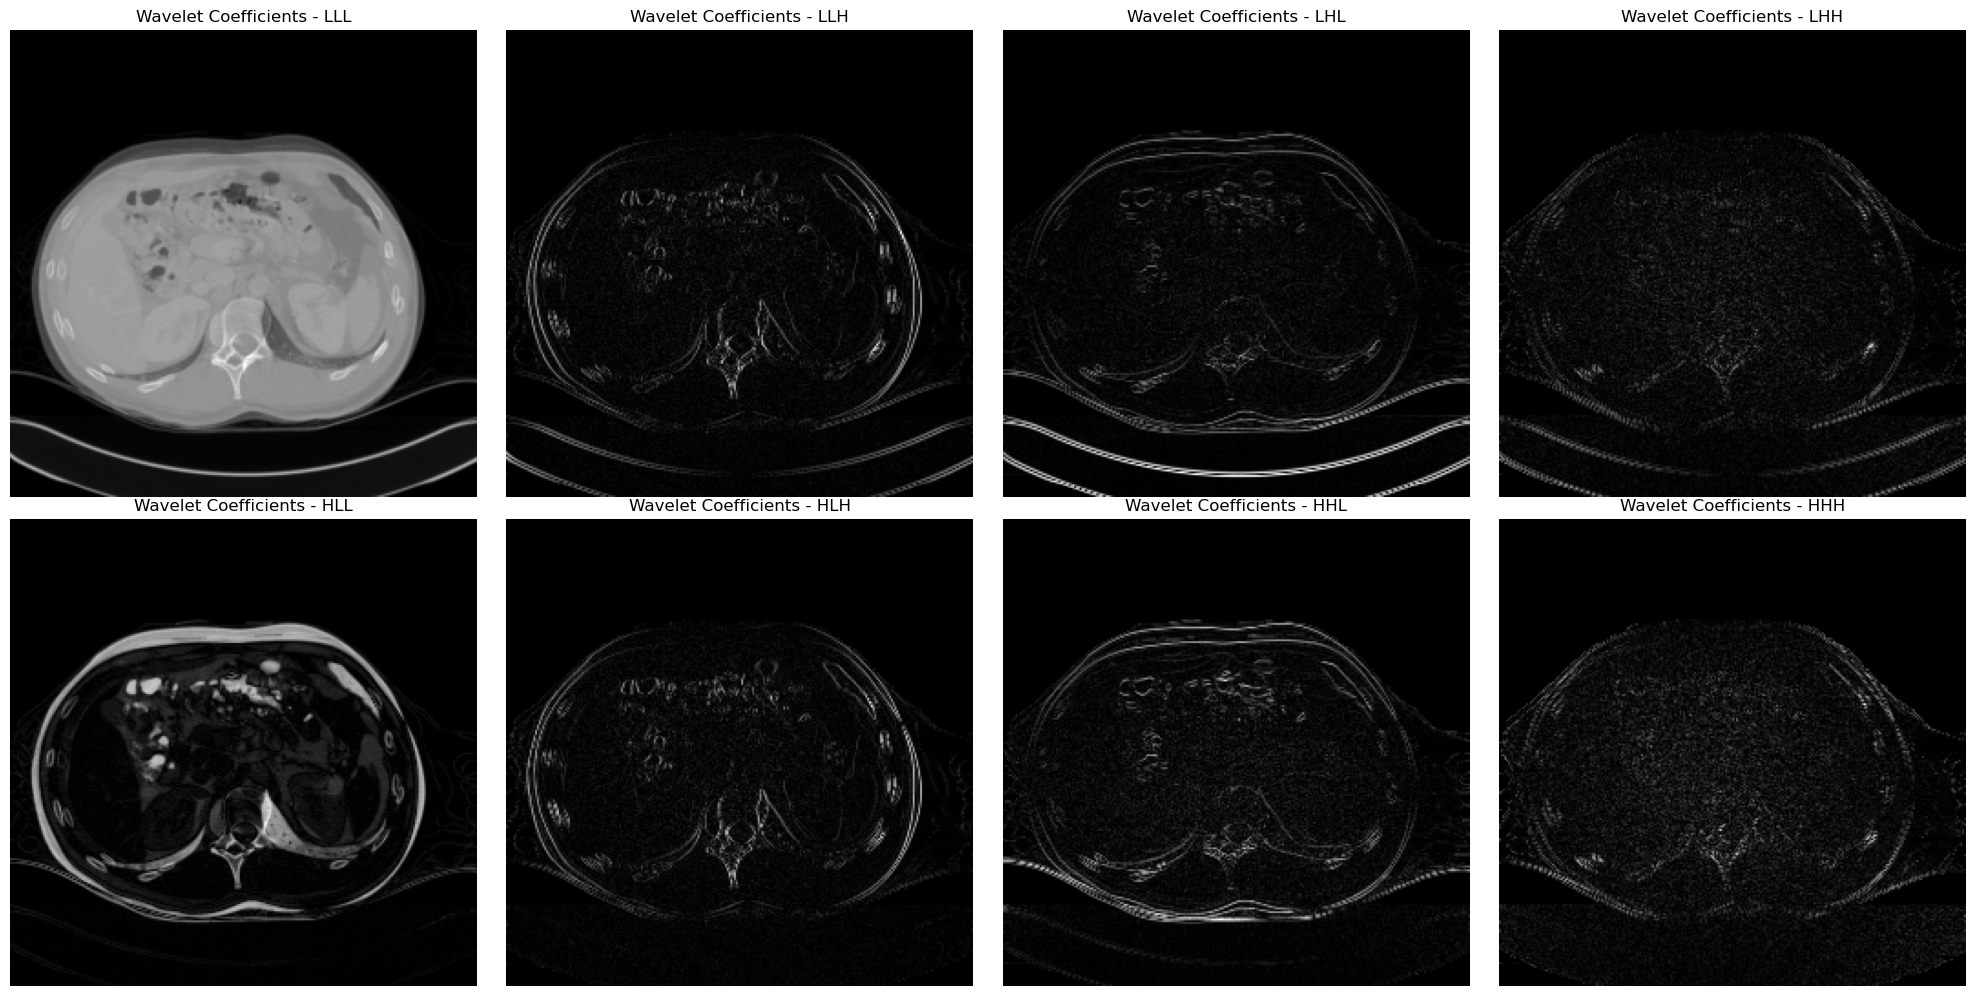

In [13]:
# Perform 3D wavelet transform
wavelet_coeffs_3d = perform_3d_wavelet_transform(dicom_data)
display_images(wavelet_coeffs_3d, 'Wavelet Coefficients', '3D')

Sub-band LLL has correct shape (39, 256, 256)
Sub-band LLH has correct shape (39, 256, 256)
Sub-band LHL has correct shape (39, 256, 256)
Sub-band LHH has correct shape (39, 256, 256)
Sub-band HLL has correct shape (39, 256, 256)
Sub-band HLH has correct shape (39, 256, 256)
Sub-band HHL has correct shape (39, 256, 256)
Sub-band HHH has correct shape (39, 256, 256)


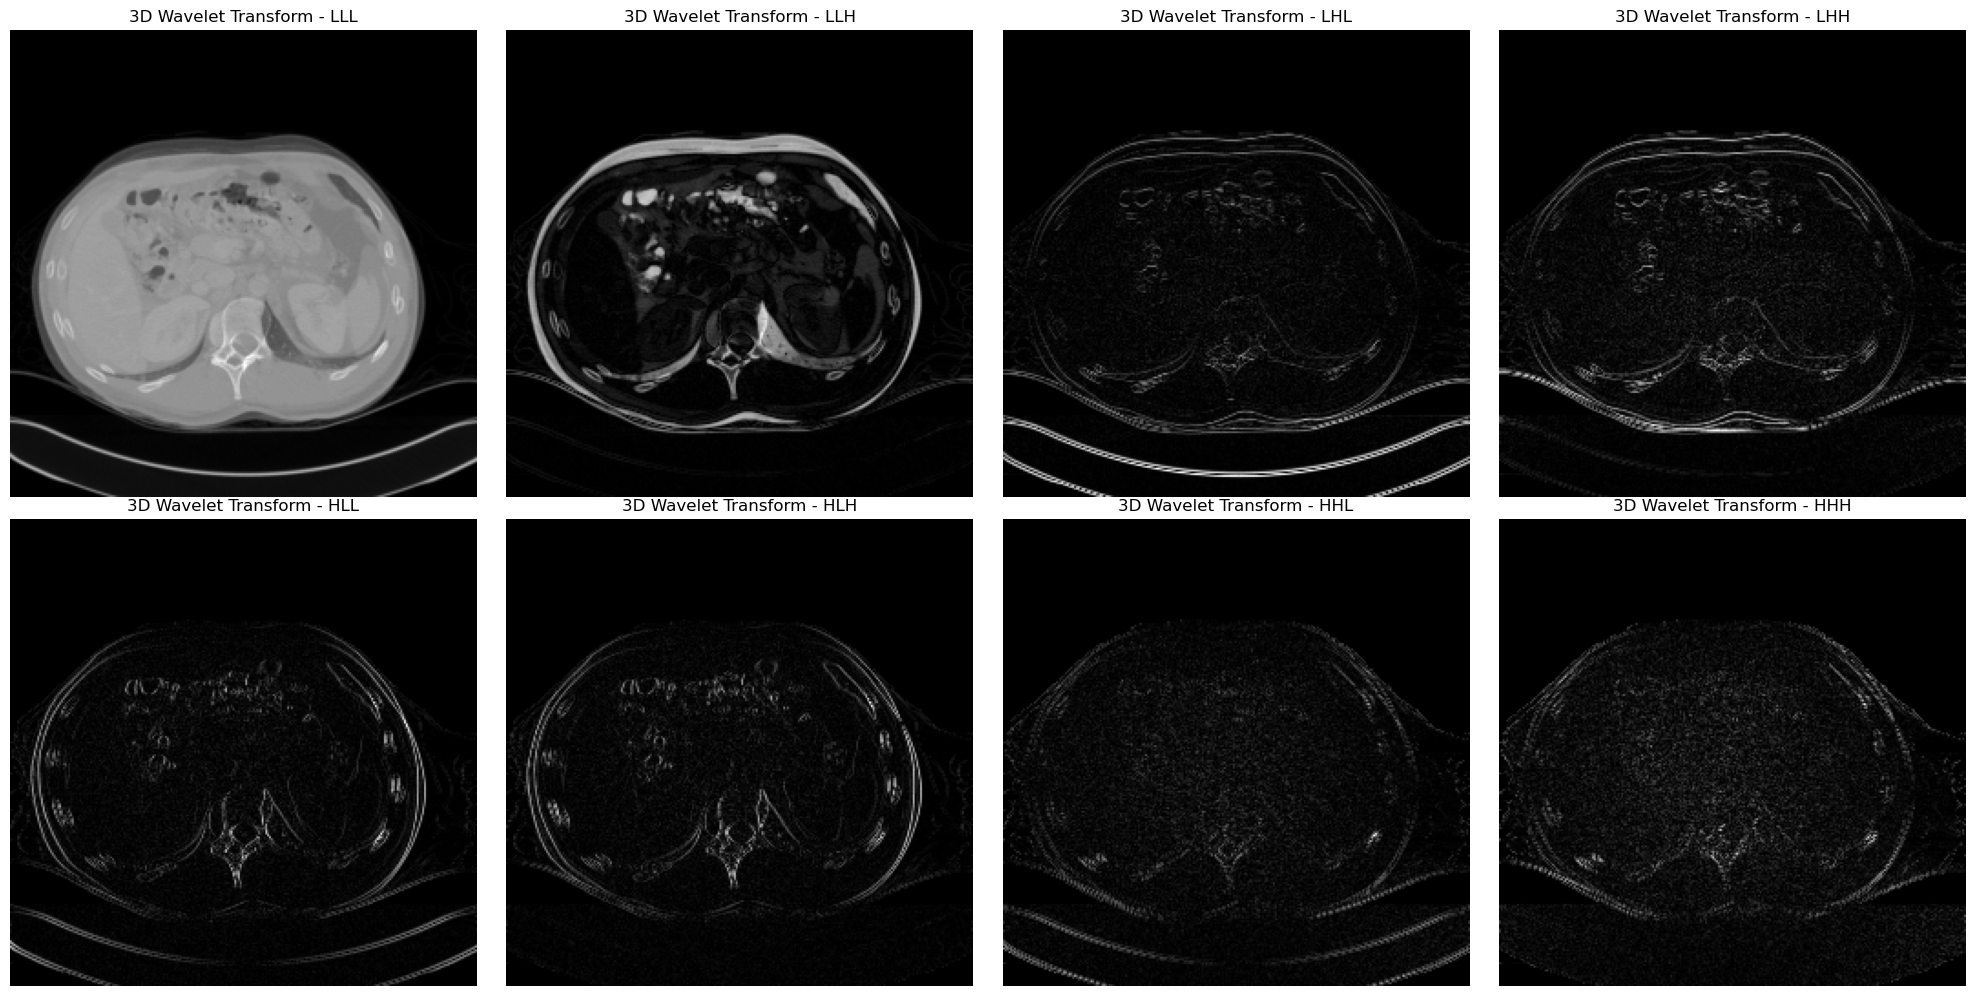

In [14]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt

def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".dcm"):
            filepath = os.path.join(directory, filename)
            dicom_files.append(pydicom.dcmread(filepath).pixel_array)
    return np.array(dicom_files)

def convolve_and_subsample(data, filter):
    result = []
    filter_size = len(filter)
    step = 2  # Subsampling factor

    for i in range(0, len(data) - filter_size + 1, step):
        sum = 0.0
        for j in range(filter_size):
            sum += data[i + j] * filter[j]
        result.append(sum)

    return np.array(result)

def perform_2d_wavelet_transform(data):
    low_pass_filter = [1/np.sqrt(2), 1/np.sqrt(2)]  # Normalized Haar filter
    high_pass_filter = [1/np.sqrt(2), -1/np.sqrt(2)]  # Normalized Haar filter

    # Apply 1D convolution and subsampling along rows
    L_rows = np.apply_along_axis(convolve_and_subsample, 1, data, low_pass_filter)
    H_rows = np.apply_along_axis(convolve_and_subsample, 1, data, high_pass_filter)

    # Apply 1D convolution and subsampling along columns
    LL = np.apply_along_axis(convolve_and_subsample, 0, L_rows, low_pass_filter)
    LH = np.apply_along_axis(convolve_and_subsample, 0, L_rows, high_pass_filter)
    HL = np.apply_along_axis(convolve_and_subsample, 0, H_rows, low_pass_filter)
    HH = np.apply_along_axis(convolve_and_subsample, 0, H_rows, high_pass_filter)

    return {"LL": LL, "LH": LH, "HL": HL, "HH": HH}

def perform_3d_wavelet_transform(data):
    # Apply 2D wavelet transform on each slice
    slices = [perform_2d_wavelet_transform(slice) for slice in data]

    # Apply 1D convolution and subsampling along the third dimension
    low_pass_filter = [1/np.sqrt(2), 1/np.sqrt(2)]  # Normalized Haar filter
    high_pass_filter = [1/np.sqrt(2), -1/np.sqrt(2)]  # Normalized Haar filter

    # Extract subbands from slices
    LL_slices = np.array([slice["LL"] for slice in slices])
    LH_slices = np.array([slice["LH"] for slice in slices])
    HL_slices = np.array([slice["HL"] for slice in slices])
    HH_slices = np.array([slice["HH"] for slice in slices])

    # Apply 1D convolution and subsampling along the third dimension for each subband
    LLL = np.apply_along_axis(convolve_and_subsample, 0, LL_slices, low_pass_filter)
    LLH = np.apply_along_axis(convolve_and_subsample, 0, LL_slices, high_pass_filter)
    LHL = np.apply_along_axis(convolve_and_subsample, 0, LH_slices, low_pass_filter)
    LHH = np.apply_along_axis(convolve_and_subsample, 0, LH_slices, high_pass_filter)
    HLL = np.apply_along_axis(convolve_and_subsample, 0, HL_slices, low_pass_filter)
    HLH = np.apply_along_axis(convolve_and_subsample, 0, HL_slices, high_pass_filter)
    HHL = np.apply_along_axis(convolve_and_subsample, 0, HH_slices, low_pass_filter)
    HHH = np.apply_along_axis(convolve_and_subsample, 0, HH_slices, high_pass_filter)

    # Return the result as a dictionary
    return {
        "LLL": LLL,
        "LLH": LLH,
        "LHL": LHL,
        "LHH": LHH,
        "HLL": HLL,
        "HLH": HLH,
        "HHL": HHL,
        "HHH": HHH
    }

def normalize(data):
    data = np.abs(data)
    data = data / np.max(data)
    return data

def display_images(data, title, transform_type):
    if transform_type == '3D':
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2x4 grid
        keys = ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']  
        for i, key in enumerate(keys):
            row, col = divmod(i, 4)
            value = data[key]
            if value.ndim == 3:
                value = value[0]  # Select the first slice if 3D
            value = normalize(value)  # Normalize the data
            axes[row, col].imshow(value, cmap='gray')
            axes[row, col].set_title(f'{title} - {key}')
            axes[row, col].axis('off')
    elif transform_type == '2D':
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1x4 grid
        keys = ['LL', 'LH', 'HL', 'HH']  # Explicit order
        for i, key in enumerate(keys):
            value = data[key]
            value = normalize(value)  # Normalize the data
            axes[i].imshow(value, cmap='gray')
            axes[i].set_title(f'{title} - {key}')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def check_subband_sizes(data, expected_shape):
    for key, subband in data.items():
        if subband.shape != expected_shape:
            print(f"Sub-band {key} has incorrect shape {subband.shape}, expected {expected_shape}")
        else:
            print(f"Sub-band {key} has correct shape {subband.shape}")

def main():
    # Directory containing the DICOM files
    dicom_directory = 'Test_Sets/CT/3/DICOM_anon/'

    # Read DICOM files
    dicom_data = read_dicom_files(dicom_directory)

    # Perform 3D wavelet transform
    transformed_data = perform_3d_wavelet_transform(dicom_data)

    # Normalize the transformed data
    normalized_data = {key: normalize(value) for key, value in transformed_data.items()}

    # Check the sizes of the sub-bands
    original_shape = dicom_data.shape
    expected_shape = tuple(dim // 2 for dim in original_shape)
    check_subband_sizes(transformed_data, expected_shape)

    # Display the images for 3D transform
    display_images(normalized_data, "3D Wavelet Transform", "3D")

if __name__ == "__main__":
    main()